In [6]:
#**************** IMPORT PACKAGES ********************
from flask import Flask, render_template, request, flash, redirect, url_for
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math, random
import datetime as dt
import json
import yfinance as yf
import tweepy
import preprocessor as p
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import xgboost as xgboost
import simplejson
from collections import deque
import random
from sklearn.linear_model import LinearRegression
from textblob import TextBlob
import constants as ct
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [11]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\prathamesh sawant\appdata\local\programs\python\python312\lib\site-packages\cloudpickle-3.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\prathamesh sawant\appdata\local\programs\python\python312\lib\site-packages\dependency_submitit_launcher-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\prathamesh sawant\appdata\local\programs\python\python312\lib\site-packages\hydra_core-1.4.0.dev1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa

In [7]:
def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year-2,end.month,end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv(''+quote+'.csv')
    if(df.empty):
        from alpha_vantage.timeseries import TimeSeries
        ts = TimeSeries(key='N6A6QT6IBFJOPJ70',output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
        #Format df
        #Last 2 yrs rows => 502, in ascending order => ::-1
        data=data.head(503).iloc[::-1]
        data=data.reset_index()
        #Keep Required cols only
        df=pd.DataFrame()
        df['Date']=data['date']
        df['Open']=data['1. open']
        df['High']=data['2. high']
        df['Low']=data['3. low']
        df['Close']=data['4. close']
        df['Adj Close']=data['5. adjusted close']
        df['Volume']=data['6. volume']
        df.to_csv(''+quote+'.csv',index=False)
    return

#******************** ARIMA SECTION ********************
def ARIMA_ALGO(df):
    from pmdarima.arima import auto_arima
    from scipy.ndimage.interpolation import shift
    from statsmodels.tsa.arima_model import ARIMA
    from pmdarima.arima import auto_arima
    import json
    uniqueVals = df["symbol"].unique()  
    len(uniqueVals)
    df=df.set_index("symbol")
    #for daily bas'is
    def parser(x):
        from datetime import datetime
        return datetime.strptime(x, '%Y-%m-%d')
    d['Date'] = pd.to_datetime(d['date']).map(lambda x: x.date())
    date = d.Date
    price = d.adjClose
    for company in uniqueVals[:10]:
        data=(df.loc[company,:]).reset_index() 
        data[['Code','Open','Low','High','Close','Adj_close','Date']] = data[['symbol','open','low','high','close', 'adjClose','date']]
        Quantity_date = data[['Code','Open','Low','High','Close','Adj_close', 'Date']]

        Quantity_date['Date'] = pd.to_datetime(Quantity_date['Date']).map(lambda x: x.date())
        Quantity_date = Quantity_date.fillna(Quantity_date.bfill())

        code = Quantity_date['Code'].to_list()
        close=Quantity_date['Close'].to_list()
        date=Quantity_date['Date'].to_list()
        open=Quantity_date['Open'].to_list()
        high=Quantity_date['High'].to_list()
        low=Quantity_date['Low'].to_list()
        Adj_close=Quantity_date['Adj_close'].to_list()

        close = pd.DataFrame(data = close, columns=["Close"])
        code = pd.DataFrame(data = code, columns=['Code'])
        date = pd.DataFrame(data = date, columns=["Date"]).astype(str)
        open = pd.DataFrame(data = open, columns=["Open"])
        high = pd.DataFrame(data = high, columns=["High"])
        low = pd.DataFrame(data = low, columns=["Low"])
        Adj_close = pd.DataFrame(data = Adj_close, columns=["Adj_close"])

        result = pd.concat([code, date, open, low, high, close, Adj_close], axis=1, ignore_index=True)

        result.columns = ['Code','Date','Open','Low','High','Close','Adj_close']

        Quantity_date = Quantity_date.drop(['Code','Date','Open','Low','High','Close'],axis =1)

        Quantity_date = Quantity_date.Adj_close
        print()
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(Quantity_date)
        plt.savefig('Trends.png')
        plt.close(fig)
        plt.show()
        import statsmodels.api as sm
        from statsmodels.tsa.stattools import adfuller    
        test_result=adfuller(Quantity_date)
        #Ho: It is non stationary
        #H1: It is stationary

        def adfuller_test(sales):
            result=adfuller(sales)
            labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
            for value,label in zip(result,labels):
                print(label+' : '+str(value) )
            if result[1] <= 0.05:
                print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
            else:
                print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        print(adfuller_test(Quantity_date))

        from pandas.plotting import autocorrelation_plot
        autocorrelation_plot(Quantity_date)
        plt.show()
        from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
        fig = plt.figure(figsize=(12,8))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(Quantity_date,ax=ax1)
        print(fig)
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(Quantity_date,ax=ax2)
        print(fig)
   
        quantity = Quantity_date.values
        size = int(len(quantity) * 0.65)
        train, test = quantity[0:size], quantity[size:len(quantity)]
        #fit in model
        
        model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                              test='adf',       # use adftest to find             optimal 'd'
                              max_p=3, max_q=3, # maximum p and q
                              m=1,              # frequency of series
                              d=None,           # let model determine 'd'
                              seasonal=False,   # No Seasonality
                              start_P=0, 
                              D=0, 
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)
        print(model_autoARIMA.summary())
        

        model_autoARIMA.plot_diagnostics(figsize=(15,8))
        plt.show()
        
        def arima_model(train, test):
            history = [x for x in train]
            predictions = [x for x in train]
            onlypreds = []
            for t in range(len(test)+7):
                model = ARIMA(history, order=(0,1 ,0))
                model = model.fit(disp=0)
                output = model.forecast()
                output = pd.DataFrame(output)
                yhat = output[0]
                predictions.append(yhat[0])
                onlypreds.append(yhat[0])
                if t < len(test):
                    obs = test[t]
                    history.append(obs)
                else:
                    obs = yhat[0]
                    history.append(obs)
            return predictions, onlypreds

        preds, onlypreds = arima_model(train, test)

        error_arima = math.sqrt(mean_squared_error(test, onlypreds[0:len(test)]))

        result["Date"] = result['Date'].astype(str).str.replace("-","/")
        x = np.append(train, onlypreds)

        pre = pd.DataFrame(x, columns=["ARIMA"])
        pre = pd.concat([pre, result['Adj_close']], axis=1)
        pre = pd.concat([pre, result['Date']], axis=1)

        idx = pd.date_range(np.array(result.Date)[-1], periods=8, freq='D')
        pre.Date[-8:] = idx.map(lambda x: x.date()).astype(str).str.replace("-","/")


        #plot graph
        print()
        #print("ARIMA model Accuracy: ")
        fig = plt.figure(figsize=(7.2,4.8),dpi=65)
        plt.plot(result['Adj_close'], label='History')
        plt.plot(pre['Date'], pre["ARIMA"], label='Predicted')
        plt.legend(loc=4)
        plt.savefig('ARIMA.png')
        plt.close(fig)

        arima_test=quantity
        arima_predi=preds
        tomorrow_ar = arima_predi[-7]


        #plt.show()
        print()
        print("####arima_predi##########################################################################")
        print("Tomorrow's",quote," Closing Price Prediction by ARIMA:",tomorrow_ar )
        print("ARIMA RMSE:",error_arima)
        print("##############################################################################")
        print()
        prices = {"Date": date, "History": price, "Forecast": arima_predi}

        return arima_predi, error_arima, tomorrow_ar, result, pre


#******************** LSTM SECTION ********************
def LSTM_ALGO(d):
    n = 100
    df1=d.reset_index()['close']
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler(feature_range=(0,1))
    df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

    ##splitting dataset into train and test split
    training_size=int(len(df1)*0.65)
    test_size=len(df1)-training_size
    train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

    import numpy
    # convert an array of values into a dataset matrix
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return numpy.array(dataX), numpy.array(dataY)

    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    time_step = n
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, ytest = create_dataset(test_data, time_step)


    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(n,1)))
    model.add(Dropout(p=0.1))

    #Add 2nd LSTM layer
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(p=0.1))

    #Add 3rd LSTM layer
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(p=0.1))

    #Add 4th LSTM layer
    model.add(LSTM(units=50))
    model.add(Dropout(p=0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=100,verbose=1)

    ### Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)

    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)

    import math
    from sklearn.metrics import mean_squared_error

    ### Test Data RMSE
    error_lstm = math.sqrt(mean_squared_error(ytest,test_predict))

    x_input=test_data[len(test_data)-n:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()


    # demonstrate prediction for next 10 days
    from numpy import array

    lst_output=[]
    n_steps=n
    i=0
    while(i<7):

        if(len(temp_input)>n):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1

    df3=df1.tolist()
    df3.extend(lst_output)
    df3=scaler.inverse_transform(df3).tolist()
    plt.plot(df3)
    tomorrow_lstm=df3[-7]
    return df3, error_lstm, tomorrow_lstm



#**************** SENTIMENT ANALYSIS **************************
def retrieving_tweets_polarity(symbol):
    auth = tweepy.OAuthHandler(ct.consumer_key, ct.consumer_secret)
    auth.set_access_token(ct.access_token, ct.access_token_secret)
    user = tweepy.API(auth)

    tweets = tweepy.Cursor(user.search, q=str(symbol), tweet_mode='extended', lang='en',exclude_replies=True).items(ct.num_of_tweets)

    tweet_list = [] #List of tweets alongside polarity
    global_polarity = 0 #Polarity of all tweets === Sum of polarities of individual tweets
    tw_list=[] #List of tweets only => to be displayed on web page
    #Count Positive, Negative to plot pie chart
    pos=0 #Num of pos tweets
    neg=1 #Num of negative tweets
    for tweet in tweets:
        count=20 #Num of tweets to be displayed on web page
        #Convert to Textblob format for assigning polarity
        tw2 = tweet.full_text
        tw = tweet.full_text
        #Clean
        tw=p.clean(tw)
        #print("-------------------------------CLEANED TWEET-----------------------------")
        #print(tw)
        #Replace &amp; by &
        tw=re.sub('&amp;','&',tw)
        #Remove :
        tw=re.sub(':','',tw)
        #print("-------------------------------TWEET AFTER REGEX MATCHING-----------------------------")
        #print(tw)
        #Remove Emojis and Hindi Characters
        tw=tw.encode('ascii', 'ignore').decode('ascii')

        #print("-------------------------------TWEET AFTER REMOVING NON ASCII CHARS-----------------------------")
        #print(tw)
        blob = TextBlob(tw)
        polarity = 0 #Polarity of single individual tweet
        for sentence in blob.sentences:

            polarity += sentence.sentiment.polarity
            if polarity>0:
                pos=pos+1
            if polarity<0:
                neg=neg+1

            global_polarity += sentence.sentiment.polarity
        if count > 0:
            tw_list.append(tw2)

        tweet_list.append(Tweet(tw, polarity))
        count=count-1
    global_polarity = global_polarity / len(tweet_list)
    neutral=ct.num_of_tweets-pos-neg
    if neutral<0:
        neg=neg+neutral
        neutral=20
    print()
    print("##############################################################################")
    print("Positive Tweets :",pos,"Negative Tweets :",neg,"Neutral Tweets :",neutral)
    print("##############################################################################")
    print()
    labels=['Positive','Negative','Neutral']
    sizes = [abs(pos),abs(neg),abs(neutral)]
    explode = (0, 0, 0)

    pie = pd.DataFrame(sizes, columns = ["sizes"])
    pie['labels'] = labels
    big_data = {"sizes": np.array(pie.sizes), "labels": np.array(pie.labels)}
    df2=pd.DataFrame(big_data)
    k = df2.to_dict('records')
    out_file = open("static/assets/js/dashboard/pie.json", "w", encoding='utf-8') 
    simplejson.dump(k, out_file, ensure_ascii=False, indent=4)


    fig = plt.figure(figsize=(7.2,4.8),dpi=65)
    fig1, ax1 = plt.subplots(figsize=(7.2,4.8),dpi=65)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig('static/SA.png')
    plt.close(fig)
    #plt.show()
    if global_polarity>0:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Positive")
        print("##############################################################################")
        print()
        tw_pol="Overall Positive"
    else:
        print()
        print("##############################################################################")
        print("Tweets Polarity: Overall Negative")
        print("##############################################################################")
        print()
        tw_pol="Overall Negative"
    return global_polarity,tw_list,tw_pol,pos,neg,neutral



def recommending(df, global_polarity,today_stock,mean):
    if today_stock.iloc[-1]['adjClose'] < mean:
        if global_polarity > 0:
            print()

            idea="RISE"
            decision="BUY"
            print()
            print("##############################################################################")
            print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
        elif global_polarity < 0:
            print()
            idea="FALL"
            decision="SELL"
            print()
            print("##############################################################################")
            print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
    else:
        print()
        idea="FALL"
        decision="SELL"
        print()
        print("##############################################################################")
        print("According to the DL Predictions and Sentiment Analysis of Tweets, a",idea,"in",quote,"stock is expected: ",decision)
    return idea, decision

[*********************100%%**********************]  1 of 1 completed


##############################################################################
Today's AAPL Stock Data: 
           Date        Open        High         Low       Close   Adj Close  \
942  2023-09-29  172.020004  173.070007  170.339996  171.210007  170.338364   

       Volume  
942  51814200  


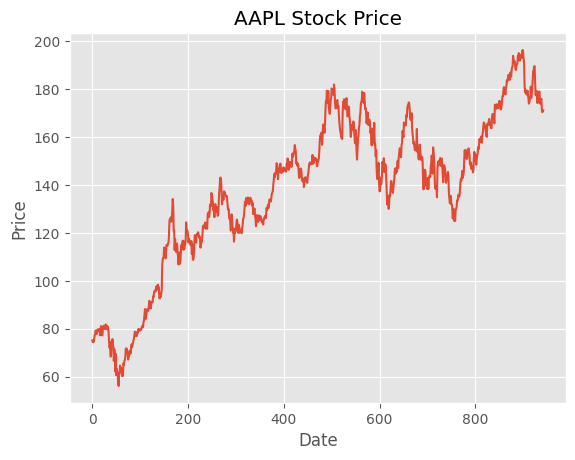

ARIMA Model Forecasted Prices for Next 7 days:
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
Recommendation Idea: Hold
Decision: No Action


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

class Tweet(object):
    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity

# Fetching stock data
quote = 'AAPL'
d = yf.download(quote, start='2020-01-01', end='2023-10-01')

# Process the data
d.dropna(inplace=True)
d.to_csv(quote + '.csv')  # Optional: Save to CSV
d = pd.read_csv(quote + '.csv')

# Analyzing the data
today_stock = d.iloc[-1:]

print("##############################################################################")
print("Today's", quote, "Stock Data: ")
print(today_stock)

# Plotting the closing price
plt.plot(d['Close'])
plt.title(f"{quote} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Predictions using ARIMA
def ARIMA_ALGO(df):
    model = auto_arima(df['Close'], seasonal=False, stepwise=True)
    forecast = model.predict(n_periods=7)
    return forecast, None, None, None, df

arima_predi, error_arima, tomorrow_ar, i, pre = ARIMA_ALGO(d)

# Creating predictions DataFrame
df3 = pd.DataFrame({
    'Date': pd.date_range(start=pd.to_datetime(d['Date'].iloc[-1]) + pd.Timedelta(days=1), periods=7),
    'Adj_close': np.nan  # Adjust this if you have a prediction for adjusted close
})
df3['ARIMA'] = arima_predi

# Combine predictions
all_pred = pd.concat([df3['Date'], df3['Adj_close'], df3['ARIMA']], axis=1)

# Analyzing Tweets (Define this function)
def retrieving_tweets_polarity(quote):
    # Placeholder function: Implement your tweet retrieval and sentiment analysis logic here
    return 0, [], [], 0, 0, 0

polarity, tw_list, tw_pol, pos, neg, neutral = retrieving_tweets_polarity(quote)
dates = np.array(all_pred["Date"].tail(7)).reshape(-1, 1)

print("ARIMA Model Forecasted Prices for Next 7 days:")
forecast_set_ar = np.round(all_pred["ARIMA"].tail(7).to_numpy(), 2).reshape(-1, 1)
mean = d["Adj Close"].tail(7).mean()  # Ensure the column name matches

print(forecast_set_ar)

# Generate recommendation (Define this function)
def recommending(i, polarity, today_stock, mean):
    # Placeholder function: Implement your recommendation logic here
    return "Hold", "No Action"  # Example return values

idea, decision = recommending(i, polarity, today_stock, mean)
today_stock = today_stock.round(2)

# Display the recommendations
print("Recommendation Idea:", idea)
print("Decision:", decision)
